In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as datetime
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})


# Ajustes en los archivos antes de procesar

In [3]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [4]:
# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)


Timestamp('2018-04-02 20:43:21.574816')

# Empieza el analisis

In [5]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [6]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [7]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [8]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [9]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [10]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,41.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


## Ver postulaciones de secundario en curso y vistas hechas al respecto (vistas, postulaciones, área de trabajo).


In [41]:
postulantes_sec = postulantes.loc[(postulantes['nombre'] == 'Secundario') & (postulantes['estado'] == 'En Curso')]
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0


In [42]:
#postulantes_1 = postulantes_sec[postulantes_sec.isna().any(axis=1)]
#null_columns=postulantes_sec.columns[postulantes_sec.isnull().any()]
#print(postulantes_sec[postulantes_sec.isnull().any(axis=1)][null_columns].head())
#aa = postulantes_sec.dropna(axis=0)

In [ ]:
#pd.to_datetime(postulantes_sec['fechapostulacion'])
#postulantes_sec['edad'] = (now - pd.to_datetime(postulantes_sec['fechanacimiento'])).astype('<m8[Y]')
#dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_sec = postulantes_sec.loc[(postulantes_sec['edad'] >= 18) & (postulantes_sec['edad'] <= 65)]
#postulantes_sec.sort_values('age')
#veo el promedio de edad que utilizan la pagina y poseen secundario en curso
pd.to_numeric(postulantes_sec['edad'])

In [53]:
#obtengo las decadas correspondientes para agrupar
postulantes_sec['decil'] = np.floor( postulantes_sec['edad'].apply(lambda x: x /10) )
postulantes_sec['decil'] = postulantes_sec['decil'].apply(lambda x: x*10)
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad,decil
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0,40.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0,40.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0,30.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0,30.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0,30.0


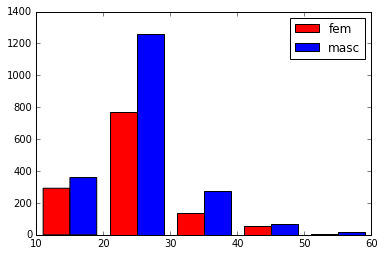

In [103]:
#diferencio entre mujeres y hombres
sec_fem = postulantes_sec.loc[postulantes_sec['sexo'] == 'FEM']
sec_masc = postulantes_sec.loc[postulantes_sec['sexo'] == 'MASC']
#hist_sec = postulantes_sec['decil'].hist(bins=5,grid=False,color='g')
#hist_sec = plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['red', 'blue'], set_title='AAA')
#hist_sec.set_title('Edades Secundario En Curso')
#hist_sec.set_xlabel('Edades en Decadas')
#hist_sec.set_ylabel('Cantidad de postulantes')
plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['red', 'blue'], label=['fem','masc'])
plt.legend()


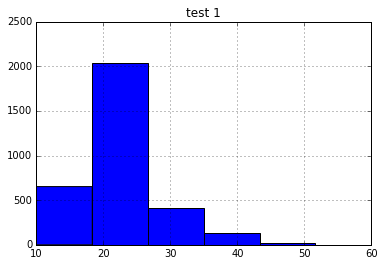